In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from tqdm import tqdm

# Learning to act

### Robin Uhrich* and Ieva Kerseviciute* 

*equal contribution

We will program an actor-critic to learn a policy on the maze world we used for exercise 3 (see section 13.5 in Sutton & Barto for a full treatment of actor-critic). Our actor will be a direct actor, learning a table M of action propensities, for each state and each action. These get turned into an action through a softmax. Our critic, instantiating the value function $V$, will be the product of a state representation $X$ and learned weights $w$, such that $V(s) = X(s) \times w$, for any state $s$. We will put a reward at location $(1, 1)$ into our maze environment.

In [2]:
def running_mean(x, N):
    """
    Calculates the moving average
    
    :param x: 1D numpy array
    :param N: window size for the moving average
    :return: 1D numpy array of running mean with a window size N
    """

    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

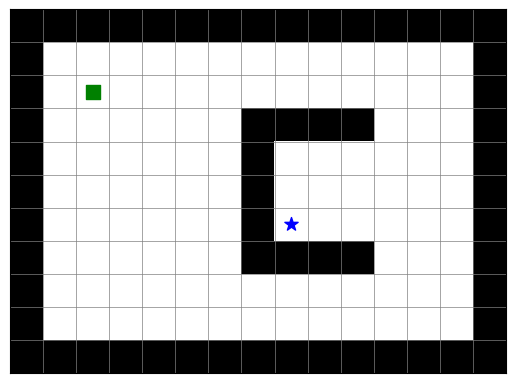

In [3]:
maze = np.zeros((9, 13))

# Place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# Define start position
start = (6, 8)

# Add outer maze walls
pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad

# Define goal position (we abuse function scoping a bit here,
# later we will change the goal, which will automatically change
# the goal in our actor critic as well)

# Note, we change this from (1, 1) because the original maze
# does not contain the outer walls
goal = (2, 2)
goal_state = goal[0] * maze.shape[1] + goal[1]
goal_value = 10


def plot_maze(maze, start = None, end = None, ax = None):
    """
    Plots the maze
    
    :param maze: 2D numpy array with maze structure (1 for wall, 0 for path)
    :param start: starting position in the maze
    :param end: goal position in the maze
    :param ax: matplotlib axis
    """

    plot_ground = ax if ax is not None else plt

    plot_ground.imshow(maze, cmap = "binary")

    for i in range(maze.shape[0]):
        plot_ground.plot([-0.5, maze.shape[1] - 0.5], [i - 0.5, i - 0.5], c = "gray", lw = 0.5)
    for i in range(maze.shape[1]):
        plot_ground.plot([i - 0.5, i - 0.5], [-0.5, maze.shape[0] - 0.5], c = "gray", lw = 0.5)

    if start is not None:
        plot_ground.scatter(start[1], start[0], marker = "*", color = "blue", s = 100)
    if end is not None:
        plot_ground.scatter(end[1], end[0], marker = "s", color = "green", s = 100)

    if ax is not None:
        plot_ground.set_xticks([])
        plot_ground.set_yticks([])
    else:
        plot_ground.xticks([])
        plot_ground.yticks([])


def plot_path(maze, path, start = None, end = None, ax = None):
    """
    Plots the maze and a path in it
    
    :param maze: 2D numpy array with maze structure (1 for wall, 0 for path)
    :param path: 2D numpy array specifying the path trajectory, shape (n_steps, 2)
    :param start: starting position in the maze
    :param end: goal position in the maze
    :param ax: matplotlib axis
    """

    plot_maze(maze, start = start, end = end, ax = ax)
    path = np.array(path)

    plot_ground = ax if ax is not None else plt
    
    plot_ground.plot(path[:, 1], path[:, 0], c = "red", lw = 3)
    plot_ground.scatter(path[0, 1], path[0, 0], marker = "*", color = "blue", s = 100)
    plot_ground.scatter(path[-1, 1], path[-1, 0], marker = "*", color = "green", s = 100)


plot_maze(maze, start, goal)

In [4]:
def compute_transition_matrix(maze):
    """
    For a given maze, compute the transition matrix from any state to any other
    state under a random walk policy
    
    :param maze: 2D numpy array with maze structure (1 for wall, 0 for path)
    :return: 
    """

    # Create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # Iterate over all states, filling in the transition probabilities to all
    # other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # Check if state is valid
            if maze[i, j] == 0:
                # Iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # Check if new state is valid
                    # noinspection PyChainedComparisons
                    if new_i >= 0 and new_i < maze.shape[0] and \
                            new_j >= 0 and new_j < maze.shape[1] and \
                            maze[new_i, new_j] == 0:
                        transitions[i * maze.shape[1] + j, new_i * maze.shape[1] + new_j] = 1

    # Normalize transitions
    transitions /= transitions.sum(axis = 1, keepdims = True)

    # Remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

In [5]:
def analytical_sr(transitions: np.ndarray, gamma: float) -> np.ndarray:
    """
    Calculate the closed form solution for successor representation.
    Equal to the infinite product.
    
    :param transitions: transition matrix from state to state (np.ndarray)
    :param gamma: discount factor (float)
    :return: updated transition matrix (np.ndarray)
    """
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

In [6]:
def learn_from_traj(succ_repr, trajectory, gamma = 0.98, alpha = 0.05):
    """
    Update a given successor representation (for the state at which the
    trajectory starts) using discount factor gamma and learning rate alpha
    
    :param succ_repr: current successor representation (np.ndarray)
    :param trajectory: 
    :param gamma: discount factor (float)
    :param alpha: learning rate (float)
    :return: updated successor representation (np.ndarray)
    """

    observed = np.zeros_like(succ_repr)

    for i, state in enumerate(trajectory):
        observed[state] += gamma ** i

    succ_repr += alpha * (observed - succ_repr)

    return succ_repr

# Part 1

Fill in the actor-critic function in the provided template. We will learn through a number of episodes of interacting with the maze environment, an episode ends once the reward located at $(1, 1)$ is reached. Besides the framework for this, you will have to derive the update equation for the action propensities $M$ (does require some steps, similar to what we once did in the tutorial) and the update equation for the $w$s parameterizing the value function (very straightforward). For our state representation $X$, we will simply use a one-hot encoding of the current state (though you should write your actor-critic in such a way as to accommodate different representations, as we will use a different one in the next exercise). Let the actor-critic run for 1000 episodes, keeping track of how much summed, discounted reward it received during each episode. Plot this evolution of reward acquisition.

In [7]:
def softmax(x: np.ndarray) -> np.ndarray:
    exp = np.exp(x)
    return exp / exp.sum()

In [8]:
def normal_start() -> int:
    """
    Returns the index of the start state

    Returns:
        int: state index
    """
    state = state2int(np.array(start))
    return state


def int2state(state_integer: np.ndarray) -> np.ndarray:
    """
    Convert an array of integer into an array of 2D coordinates

    Args:
        state_integer (np.ndarray): integer array (n_samples,)

    Returns:
        np.ndarray: coordinate array (n_samples, 2)
    """
    row = state_integer // maze.shape[1]
    column = state_integer - (maze.shape[1] * row)
    coords = np.stack([row, column]).T
    return coords


def state2int(state: np.ndarray) -> np.ndarray:
    """
    Convert 2D coordinates to integer array

    Args:
        state (np.ndarray): (2, n_samples)

    Returns:
        np.ndarray: (n_samples,)
    """
    state = state[0] * maze.shape[1] + state[1]
    return state


def get_valid_action_mask(state: np.ndarray) -> np.ndarray:
    """
    Returns binary mask which action you can take and which not.
    1 means you can move there, 0 you cannot.

    Args:
        state (np.ndarray): 2D state coordinates (x, y)

    Returns:
        np.ndarray: (4,) binary mask
    """
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype = int)
    move_options = state[None] + possible_moves
    # remove those moves which run into a barrier
    move_options = 1 - maze[*move_options.T]
    return move_options


def actor_critic(
        state_representation,
        n_steps,
        alpha,
        gamma,
        n_episodes,
        update_sr = False,
        start_func = normal_start,
        v_init = 0,
        quiet: bool = False,
        seed: int = 42
):
    """
    Actor-critic algorithm for learning to navigate a maze.
    
    :param state_representation: (np.ndarray) 2D state representation array of shape (n_states, n_states).
    Gives the representation for each, which is either a 1-hot vector (so e.g. state_representation[15]
    is a vector of size n_states which is 0 everywhere, except 1 at index 15), or the SR for each state.
    :param n_steps: number of actions in each episode before it gets cut off, an episode also ends when
    the agent reaches the goal.
    :param alpha: learning rate
    :param gamma: discount factor
    :param n_episodes: number of episodes to train the agent
    :param update_sr: whether to update the successor representation after each episode
    :param start_func: a function for specifying the starting state
    :param v_init: initial state-value function
    :param quiet: whether to print progress or not
    :param seed: random seed
    
    :return: M-values, weights, earned rewards, trajectories in each episode,
    final state representation, and a list of starting locations
    """
    np.random.seed(seed)

    state_representation = state_representation.copy()
    n_states = len(state_representation)

    # Initialize the M-values
    M = np.ones((n_states, 4), dtype = float) / 4

    # Initialize state-value function
    V_weights = v_init * np.ones(n_states)

    earned_rewards = np.zeros(n_episodes)
    starting_pos = np.zeros((n_episodes, 2), dtype = int)

    # Define possible moves
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype = int)
    trajectories = []

    iterator = range(n_episodes)
    if not quiet:
        iterator = tqdm(iterator)

    for episode_idx in iterator:
        # Reset trajectory and place in starting position
        trajectory = np.zeros(n_steps, dtype = int)
        state = start_func()
        starting_pos[episode_idx] = int2state(state)
        discount = 1

        for t in range(n_steps):
            # Save state in trajectory
            trajectory[t] = state

            # Get possible actions, randomly select one of them and perform step
            state_coords = int2state(state)
            action_mask = get_valid_action_mask(state_coords)

            action_logits = M[state]
            action_logits[action_mask == 0] = -np.inf  # after softmax() -> 0
            action_distr = softmax(action_logits)

            action_idx = np.random.choice(4, p = action_distr)
            next_state_coords = state_coords + possible_moves[action_idx]
            next_state = state2int(next_state_coords)

            # Calculate the value and reward of current and next state
            reward = 0
            current_value = state_representation[state] @ V_weights
            next_value = state_representation[next_state] @ V_weights
            if next_state == goal_state:
                reward = goal_value
                earned_rewards[episode_idx] += discount * reward
                next_value = 0

            # Calculate TD error
            td_error = reward + gamma * next_value - current_value

            # Update weights
            V_weights += alpha * td_error * state_representation[state]

            # Update M-values
            log_grad = np.zeros(4)
            log_grad[action_idx] += 1
            M[state] += alpha * gamma ** t * td_error * log_grad

            # Check if goal is reached
            if next_state == goal_state:
                # Truncate to include only the visited positions
                trajectory = trajectory[: t + 1]
                break

            # Update SR
            if update_sr:
                state_repr_td_error = gamma * state_representation[next_state] - state_representation[state]
                state_representation[state] += alpha * state_repr_td_error

            state = next_state
            discount *= gamma

        # Always include the goal state (for plotting purposes)
        if t != n_steps - 1:
            trajectory = np.array([*trajectory.tolist(), goal_state])

        trajectories.append(trajectory)

    return M, V_weights, earned_rewards, trajectories, state_representation, starting_pos

In [9]:
transitions = compute_transition_matrix(maze)
state_representation = np.eye(len(transitions))
_, V, earned_rewards, traj, _, _ = actor_critic(
    state_representation,
    n_steps = 300,
    alpha = 0.05,
    gamma = 0.99,
    n_episodes = 1000
)

/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_77250/237609977.py:30: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis = 1, keepdims = True)
100%|██████████| 1000/1000 [00:02<00:00, 363.41it/s]


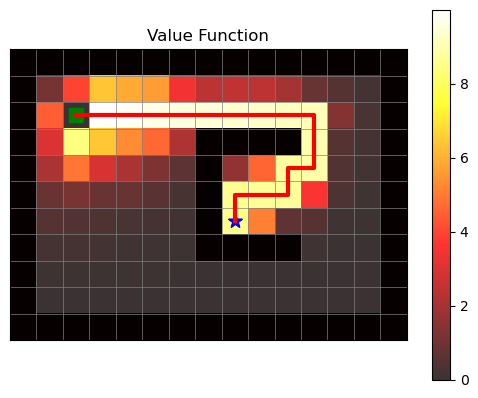

In [10]:
plot_path(maze, int2state(traj[-1]), start, goal)
plt.imshow(V.reshape(maze.shape), cmap="hot", alpha=0.8)
plt.colorbar()
plt.title("Value Function")
plt.show()

The plot above visualizes the value function in the maze and overlays the trajectory of the agent (red line) navigating from the starting position (blue star) to the goal (green square). The red trajectory shows that the agent is following a learned policy and prefers actions that lead it through higher-value states. The value function is well-learned and reflects the agent’s ability to maximize rewards.

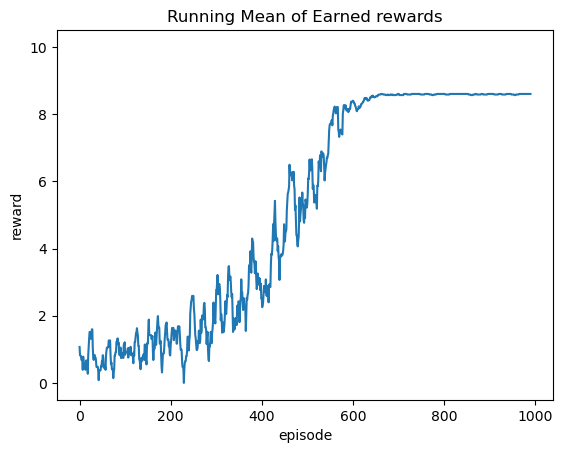

In [11]:
plt.plot(running_mean(earned_rewards, 10))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()

The plot above shows the earned rewards across a number of learning episodes (running mean, smoothed over 10 points). Initially, the rewards start slow and fluctuate significantly, indicating that the agent is in its exploration stage, trying to learn about the environment and potentially taking suboptimal actions. After around 200 learning episodes, the rewards gradually increase (however, they still fluctuate). Now, the agent is learning a better policy, improving its ability to maximize the rewards. Fluctuations suggest that the agent still actively explores the environment, tries riskier actions and refines the policy. Finally, after around 600 episodes the rewards plateau at a high value (~8-9). At this point, the agent has converged to a near-optimal or optimal policy. The reduced fluctuations indicate that the agent is now performing consistently well and exploiting the learnt policy.

# Part 2

Now, we will use the successor representation (SR) to improve learning speed. Imagine the agent had ample exposure to the environment under a random policy, and acquired an accurate SR for each state. We thus create a value function as such: $V(s) = SR(s) \times w$. Use the provided function to compute the SR for all states, and use this as your state representation. This might require you to make some parts of your code more general, but the same code can run both versions of actor-critic in principle. Compare the evolution of reward acquisition for this new actor-critic. What do you see and how do you explain this? Plot the learned value function overlaid onto the maze.

In [12]:
# Compute the SR for all states, based on the transition matrix
# Note that we use a lower discounting here, to keep the SR more local
analytical_state_repr = analytical_sr(transitions, 0.6)

_, V, earned_rewards, traj, _, _ = actor_critic(
    analytical_state_repr,
    n_steps = 300,
    alpha = 0.05,
    gamma = 0.99,
    n_episodes = 1000,
    update_sr = False
)

100%|██████████| 1000/1000 [00:01<00:00, 774.49it/s]


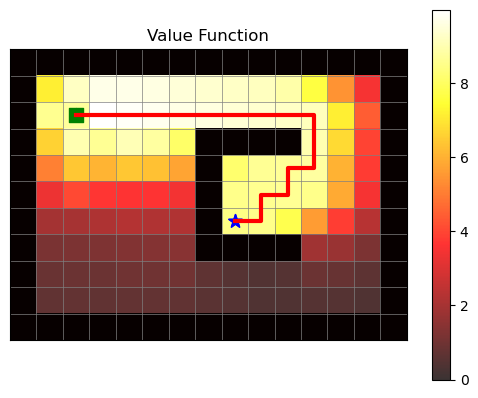

In [13]:
plot_path(maze, int2state(traj[-1]), start, goal)
plt.imshow((analytical_state_repr @ V).reshape(maze.shape), cmap = "hot", alpha = 0.8)
plt.colorbar()
plt.title("Value Function")
plt.show()

Now, the agent knows the structure of the environment and can navigate it more optimally when looking for the goal location. Comparing to the same plot (of the value function overlaid over the maze) in part 1, we notice that the agent chooses to explore more optimal paths leading to reward more frequently (as indicated by the brighter color gradient surrounding the final learnt trajectory). Now, the agent avoids exploring the environment unnecessarily as it already has this information.

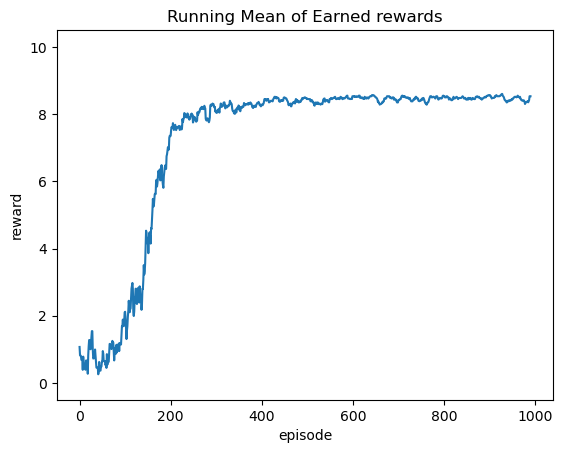

In [14]:
plt.plot(running_mean(earned_rewards, 10))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()

Comparing the earned rewards over time using SR and using one-hot encoding, it is noticeable that the agent skips the initial learning stage. The reward values still fluctuate as the agent learns the policy, but this stage is relatively short as the agent is already familiar with the environment. Now, the policy converges after around 200 episodes (as compared to 600 in the case of one-hot encoding).

# Part 3

Next, we study the effects of re-learning the SR while learning the policy. Make two extensions to your code: Rather than always starting an episode at the start location, use a function which returns a random (valid) location of the maze to start at. Additionally, also update the SR while interacting with the environment. You can do this with the provided function `learn_from_traj` after each episode, or during each episode if you programmed a temporal difference SR algorithm during exercise 3 (or want to do so now). If you use `learn_from_traj`, note that it only updates the SR of the first state of the trajectory, so you have to write some extra code to also update the SR of the states along the trajectory. Plot the SR for a couple of states of your choice which showcase what it learned while specialising to the learned policy (and, as always, elaborate a bit on what you observe).

In [15]:
def random_start():
    """
    Defines a random stating (non-wall) starting state to pass
    into the actor_critic function.
    
    :return: random starting state
    """
    
    mask = transitions.sum(axis=1)
    mask[mask == 0] = -np.inf
    p = softmax(mask)
    return np.random.choice(len(p), p=p)

In [16]:
M, V, earned_rewards, traj, learned_state_repr, starting_pos = actor_critic(
    analytical_state_repr,
    n_steps = 300,
    alpha = 0.05,
    gamma = 0.99,
    n_episodes = 1000,
    update_sr = True,
    start_func = random_start
)

100%|██████████| 1000/1000 [00:00<00:00, 1184.25it/s]


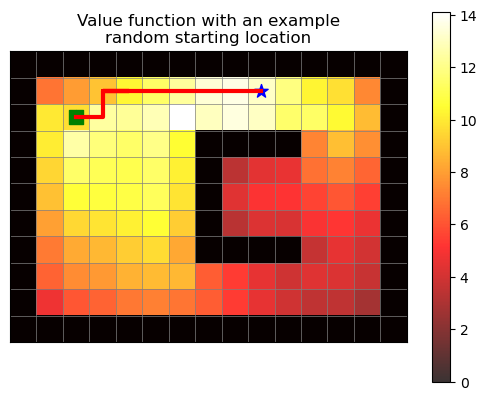

In [17]:
plot_path(maze, int2state(traj[-1]), end = goal)
plt.imshow((analytical_state_repr @ V).reshape(maze.shape), cmap = "hot", alpha = 0.8)
plt.colorbar()
plt.title("Value function with an example\nrandom starting location")
plt.show()

In this maze we do not observe a clear value function trajectory towards the goal since the agent is placed at random locations and explores the environment from there. However, there is a clear gradient towards the goal location. By updating the SR during training, the agent continuously improves its understanding of the environment and the relationships between states. Random starts force the agent to explore more, improving its ability to generalize across different starting points. As a result, it learns a policy that works from any starting location, not just a fixed starting point.

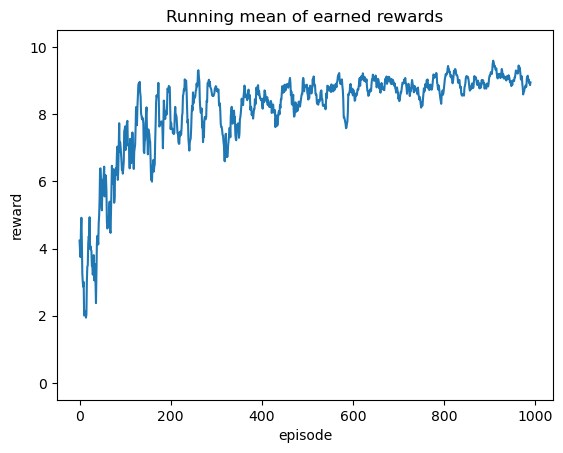

In [18]:
plt.plot(running_mean(earned_rewards, 10))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running mean of earned rewards")
plt.show()

Just like when we used the successor representation without updating it, we can see that the agent learns quickly here too. In the early episodes, there is more fluctuation in rewards since the agent is still exploring and adapting to the challenge of starting from different locations. However, the rewards stabilize much faster in this case because updating the SR helps the agent better understand the relationships between states and improves its learning process.

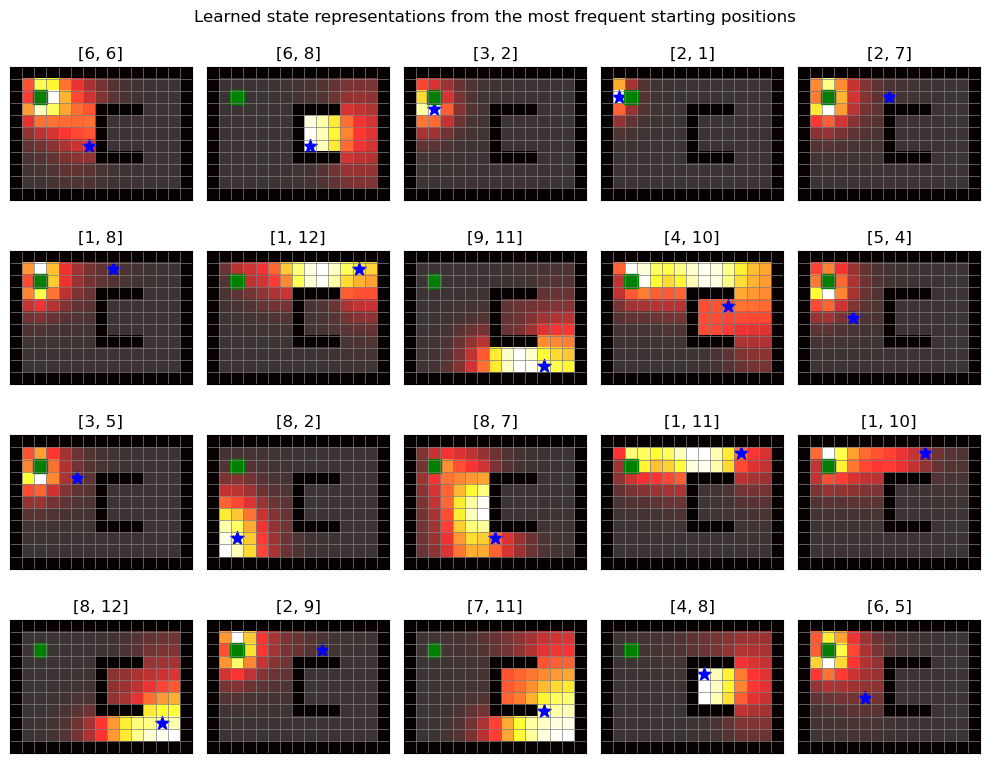

In [19]:
unique_pos, unique_count = np.unique(starting_pos, axis = 0, return_counts = True)
sorted_counts = np.argsort(unique_count)[::-1]

fig, axs = plt.subplots(nrows = 4, ncols = 5, figsize = (10, 8))

for i, ax in enumerate(axs.flatten()):
    idx = sorted_counts[i]
    coords = unique_pos[idx]
    pos = state2int(coords)
    ax.set_title(coords.tolist())
    plot_maze(maze, start = coords, end = goal, ax = ax)
    ax.imshow((learned_state_repr[pos]).reshape(maze.shape), cmap = "hot", alpha = 0.8)

fig.suptitle("Learned state representations from the most frequent starting positions")
fig.tight_layout()

In the plot above, we show learned state representations for the 20 most frequent starting positions (marked by the blue star; the green square marks the goal position). It seems that the agent is able to find the goal position quickly when the starting position is close to the goal location. In the cases where the starting point is further from the goal, it spends more time exploring the surroundings around the starting position. In general, the bright colors in the plot are concentrated around the goal position or along the optimal path towards it, indicating that the agent learned a good understanding of the environment.

# Part 4

In [165]:
stats = {"rewards": [[], []]}

goal = (6, 6)
goal_state = goal[0] * maze.shape[1] + goal[1]
for i in range(20):
    # run with random walk SR
    M_clamped, V_clamped, earned_rewards_clamped, traj_clamped, _ = actor_critic(
        analytical_state_repr,
        300,
        0.05,
        0.99,
        1000,
    )
    stats["rewards"][0].append(earned_rewards_clamped)

    # run with updated SR
    M_relearned, V_relearned, earned_rewards_relearned, traj_relearned, learned_state_repr_relearned = actor_critic(
        learned_state_repr,
        300,
        0.05,
        0.99,
        1000,
        update_sr=True,
    )
    stats["rewards"][1].append(earned_rewards_relearned)

100%|██████████| 1000/1000 [00:01<00:00, 620.13it/s]


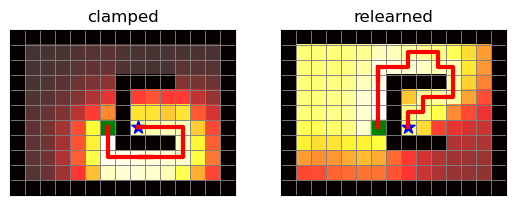

In [166]:
# plot state-value function
fig, ax = plt.subplots(ncols=2)
plot_maze(maze, None, goal, ax=ax[0])
plot_path(maze, int2state(traj_clamped[-1]), ax=ax[0])
ax[0].imshow((analytical_state_repr @ V_clamped).reshape(maze.shape), cmap="hot", alpha=0.8)
plot_maze(maze, None, goal, ax=ax[1])
plot_path(maze, int2state(traj_relearned[-1]), ax=ax[1])
ax[1].imshow((learned_state_repr_relearned @ V_relearned).reshape(maze.shape), cmap="hot", alpha=0.8)

ax[0].set_title("clamped")
ax[1].set_title("relearned")

plt.show()



plot the performance averages of the two types of learners


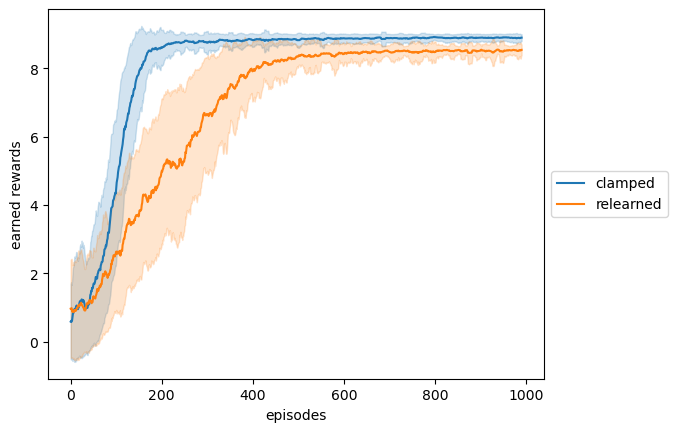

In [167]:
reward_stats = np.stack(stats["rewards"])

mean_base = reward_stats.mean(axis=1)
mean = np.stack(
    [
        running_mean(mean_base[0], 10),
        running_mean(mean_base[1], 10),
    ]
)

std_base = reward_stats.std(axis=1)
std = np.stack(
    [
        running_mean(std_base[0], 10),
        running_mean(std_base[1], 10),
    ]
)

tab10 = mpl.colormaps["tab10"]

plt.plot(mean[0], label="clamped")
plt.fill_between(
    np.arange(len(mean[0])),
    mean[0] - std[0],
    mean[0] + std[0],
    color=tab10(0),
    alpha=0.2,
)
plt.plot(mean[1], label="relearned")
plt.fill_between(
    np.arange(len(mean[1])),
    mean[1] - std[1],
    mean[1] + std[1],
    color=tab10(1),
    alpha=0.2,
)

plt.xlabel("episodes")
plt.ylabel("earned rewards")
plt.legend(loc="center left",bbox_to_anchor=(1,0.5))

# Part 5

In [168]:
# reset goal
goal = (1, 1)
goal_state = goal[0] * maze.shape[1] + goal[1]

# run some learners with different value weight w initializations
N_BOOT = 4
N_PARAMS = 5
N_EPISODES = 1000
v_inits = np.linspace(0, 10, N_PARAMS)
boot_stats = {"reward_one_hot": np.zeros((N_BOOT, N_PARAMS, N_EPISODES)), "reward_sr": np.zeros((N_BOOT, N_PARAMS, N_EPISODES))}

for v_init_idx, boot_idx in tqdm(product(range(N_PARAMS), range(N_BOOT))):
    M_one_hot, V_one_hot, earned_rewards_one_hot, traj_one_hot, _ = actor_critic(
        np.eye(len(transitions)),
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_one_hot"][boot_idx, v_init_idx] = earned_rewards_one_hot
    M_sr, V_sr, earned_rewards_sr, traj_sr, _ = actor_critic(
        analytical_state_repr,
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_sr"][boot_idx, v_init_idx] = earned_rewards_sr

20it [01:22,  4.11s/it]


Text(0.5, 1.0, 'Different value initializations 0 - 10')

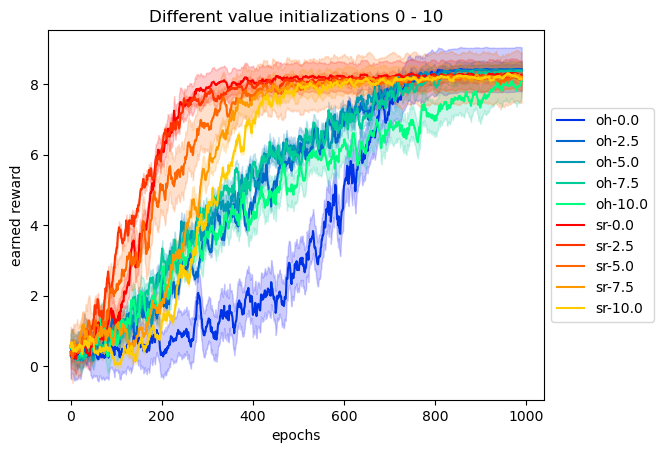

In [169]:
reward_one_hot = np.stack(boot_stats["reward_one_hot"])
reward_sr = np.stack(boot_stats["reward_sr"])


reward_one_hot = reward_one_hot.mean(axis=0)
reward_one_hot_std = reward_one_hot.std(axis=0)
reward_sr = reward_sr.mean(axis=0)
reward_sr_std = reward_sr.std(axis=0)

one_hot_cm = mpl.colormaps["winter"]
sr_cm = mpl.colormaps["autumn"]

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_one_hot[param_idx], 10),
        label=f"oh-{param}",
        color=one_hot_cm((param_idx + 1) / N_PARAMS),
    )
    plt.fill_between(
        np.arange(len(reward_one_hot[param_idx]) - 10 + 1),
        running_mean(reward_one_hot[param_idx] - reward_one_hot_std[param_idx], 10),
        running_mean(reward_one_hot[param_idx] + reward_one_hot_std[param_idx], 10),
        color=one_hot_cm(param_idx / N_PARAMS),
        alpha=0.2
    )

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_sr[param_idx], 10),
        label=f"sr-{param}",
        color=sr_cm((param_idx + 0) / N_PARAMS ),
    )
    plt.fill_between(
        np.arange(len(reward_sr[param_idx]) - 10  + 1),
        running_mean(reward_sr[param_idx] - reward_sr_std[param_idx], 10),
        running_mean(reward_sr[param_idx] + reward_sr_std[param_idx], 10),
        color=sr_cm(param_idx / N_PARAMS),
        alpha=0.2
    )
    

plt.legend(loc="center left",bbox_to_anchor=(1,0.5))
plt.xlabel("epochs")
plt.ylabel("earned reward")
plt.title("Different value initializations 0 - 10")


In [170]:
# reset goal
goal = (1, 1)
goal_state = goal[0] * maze.shape[1] + goal[1]

# run some learners with different value weight w initializations
N_BOOT = 4
N_PARAMS = 5
N_EPISODES = 1000
v_inits = np.linspace(0, 40, N_PARAMS)
boot_stats = {"reward_one_hot": np.zeros((N_BOOT, N_PARAMS, N_EPISODES)), "reward_sr": np.zeros((N_BOOT, N_PARAMS, N_EPISODES))}

for v_init_idx, boot_idx in tqdm(product(range(N_PARAMS), range(N_BOOT))):
    M_one_hot, V_one_hot, earned_rewards_one_hot, traj_one_hot, _ = actor_critic(
        np.eye(len(transitions)),
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_one_hot"][boot_idx, v_init_idx] = earned_rewards_one_hot
    M_sr, V_sr, earned_rewards_sr, traj_sr, _ = actor_critic(
        analytical_state_repr,
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_sr"][boot_idx, v_init_idx] = earned_rewards_sr

20it [02:41,  8.09s/it]


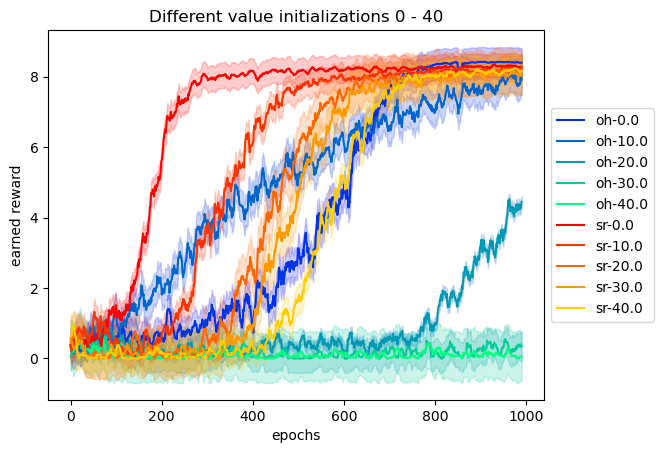

In [172]:
reward_one_hot = np.stack(boot_stats["reward_one_hot"])
reward_sr = np.stack(boot_stats["reward_sr"])


reward_one_hot = reward_one_hot.mean(axis=0)
reward_one_hot_std = reward_one_hot.std(axis=0)
reward_sr = reward_sr.mean(axis=0)
reward_sr_std = reward_sr.std(axis=0)

one_hot_cm = mpl.colormaps["winter"]
sr_cm = mpl.colormaps["autumn"]

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_one_hot[param_idx], 10),
        label=f"oh-{param}",
        color=one_hot_cm((param_idx + 1) / N_PARAMS),
    )
    plt.fill_between(
        np.arange(len(reward_one_hot[param_idx]) - 10 + 1),
        running_mean(reward_one_hot[param_idx] - reward_one_hot_std[param_idx], 10),
        running_mean(reward_one_hot[param_idx] + reward_one_hot_std[param_idx], 10),
        color=one_hot_cm(param_idx / N_PARAMS),
        alpha=0.2
    )

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_sr[param_idx], 10),
        label=f"sr-{param}",
        color=sr_cm((param_idx + 0) / N_PARAMS ),
    )
    plt.fill_between(
        np.arange(len(reward_sr[param_idx]) - 10  + 1),
        running_mean(reward_sr[param_idx] - reward_sr_std[param_idx], 10),
        running_mean(reward_sr[param_idx] + reward_sr_std[param_idx], 10),
        color=sr_cm(param_idx / N_PARAMS),
        alpha=0.2
    )
    

plt.legend(loc="center left",bbox_to_anchor=(1,0.5))
plt.xlabel("epochs")
plt.ylabel("earned reward")
plt.title("Different value initializations 0 - 40")
plt.show()